<a href="https://colab.research.google.com/github/felipefranca/python-data-visualization-imdb-dataset/blob/main/Trabalho_Final_Visualiza%C3%A7%C3%A3o_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando as bibliotecas 



In [ ]:
import warnings;warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import missingno as msno
from scipy import stats
import numpy as np
import plotly.graph_objects as go
%matplotlib inline
from collections import Counter

## Carregando o dataset e selecionando as colunas


In [ ]:
data = pd.read_csv('title_basics.csv', low_memory=False)

In [ ]:
#Limpando a base de valores "na"

df = data[~data.duplicated()]
df.dropna(inplace=True)
df.isna().sum()
data = df

##Quais são os tipos de títulos mais avaliados no IMDb ?
#### Os tipos de títulos mais recorrentes no IMDb são episódios de TV,filmes e curta-metragem seguidos por vídeos e series.

In [ ]:
titletype = [i for i in Counter(df.titleType).items()]
x = 'Tipo'
y = 'Totais'
fig = px.bar(x = [i[0] for i in sorted(titletype,key=lambda x: x[1])[::-1][:11]],y = [i[1] for i in sorted(titletype,key=lambda x: x[1])[::-1][:11]],color = [i[0] for i in sorted(titletype,key=lambda x: x[1])[::-1][:11]],template='plotly_dark')
fig.update_layout(xaxis_title = f'{str(x).title()}',yaxis_title = f'{str(y).title()}',title = f'Distribuição Baseada no Tipo de Título')
fig.show()

##Quanto tempo de duração tem os filmes ao longo do tempo ? 

#### A média de tempo de duração dos filmes está entre o intervalo de 50 a 100 minutos como podemos ver no boxplot abaixo. Eliminei os filmes com tempo de duração acima de 300 minutos por se tratar de valores que fogem da média(outliers)

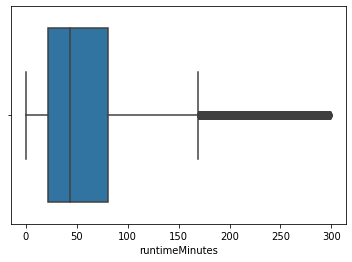

In [ ]:
conditionToEndYear = (data['endYear'] != '\\N') & (data['endYear'] != 'NaN') & (data['endYear'] != 'None') & (data['endYear'] != '')
conditionToStartYear = (data['startYear'] != '\\N') & (data['startYear'] != 'NaN') & (data['startYear'] != 'None') & (data['startYear'] != '')
conditionRuntimeMinutes = (data['runtimeMinutes'] != '\\N') & (data['runtimeMinutes'] != 'NaN') & (data['runtimeMinutes'] != 'None') & (data['runtimeMinutes'] != '')
df2 = data[(conditionRuntimeMinutes)].dropna()
df2['runtimeMinutes'] = df2['runtimeMinutes'].astype(int)
conditionToRuntimeMinutes = (df2['runtimeMinutes'] < 300)
df_filtrado = df2[(conditionToRuntimeMinutes)]
sns.boxplot(x='runtimeMinutes', data=df_filtrado)

##Quais são os tipos mais presentes nas avalizações do IMDb?

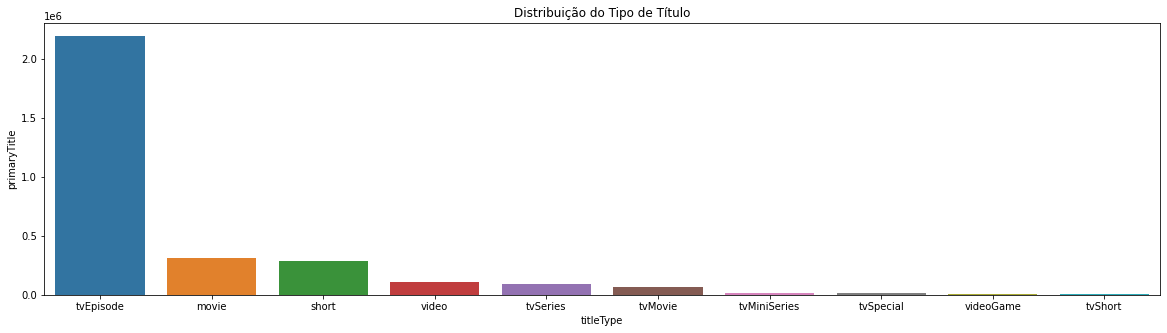

In [ ]:
key = 'titleType'
tmp = data[[key,'primaryTitle']].groupby(key).count().reset_index().sort_values('primaryTitle',ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(data=tmp, x=tmp[key], y=tmp['primaryTitle'])
plt.title(f'Distribuição do Tipo de Título')
plt.show()

## Quais são os gêneros com mais avaliações no IMDb ? 
#### Distribuição de Gêneros Dos Filmes





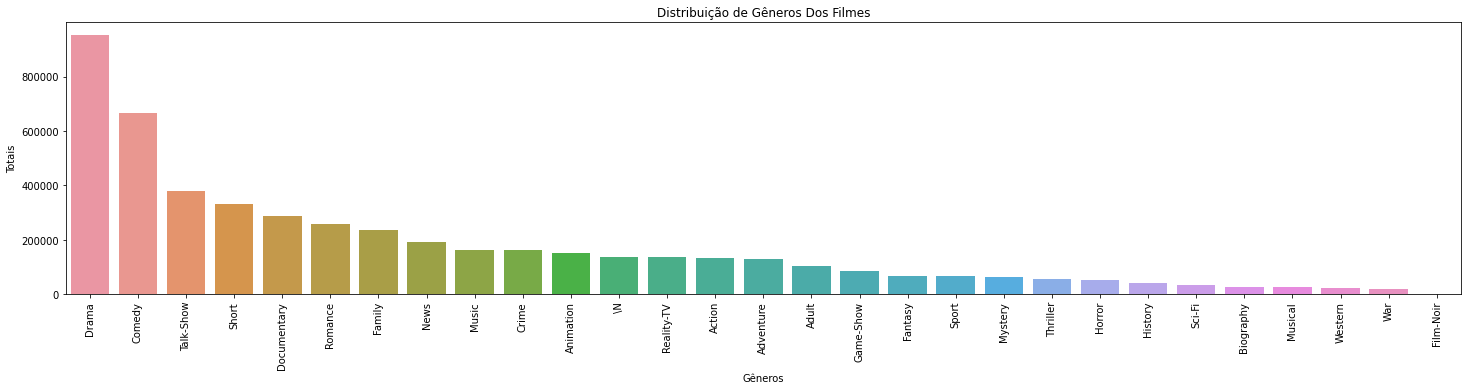

In [ ]:
genres = data['genres'].dropna()
genres_list = [str(genres_str).split(',') for genres_str in genres.unique().tolist()]
genres_list = [genres.strip() for genres in list(set(sum(genres_list,[])))]

tmp = data[['primaryTitle','genres']]
for genres in genres_list:
    tmp[genres] = tmp['genres'].apply(lambda x:1 if genres in str(x) else 0)
tmp = tmp[genres_list].sum().reset_index().sort_values(0,ascending=False)
tmp.columns = ['Gêneros','Totais']

plt.figure(figsize=(25,5))
sns.barplot(data=tmp,x='Gêneros',y='Totais')
plt.title(f'Distribuição de Gêneros Dos Filmes')
plt.xticks(rotation=90)
plt.show()

# Explorando uma nuvem de palavras que representa os gêneros mais recorrentes dos filmes

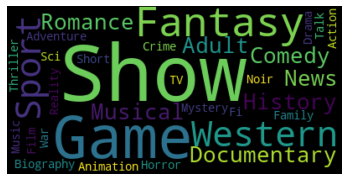

In [ ]:
df_genres = data['genres'].dropna()
genres_list = [str(genres_str).split(',') for genres_str in df_genres.unique().tolist()]
genres_list = [genres.strip() for genres in list(set(sum(genres_list,[])))]
genres_list.remove("\\N")
text = ""
for g in genres_list:
  text = text + " " + g
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Matrix Plot - Para explorar valores não preenchidos, o gráfico é uniforme pois não existe correlação de valores nulos e vazios


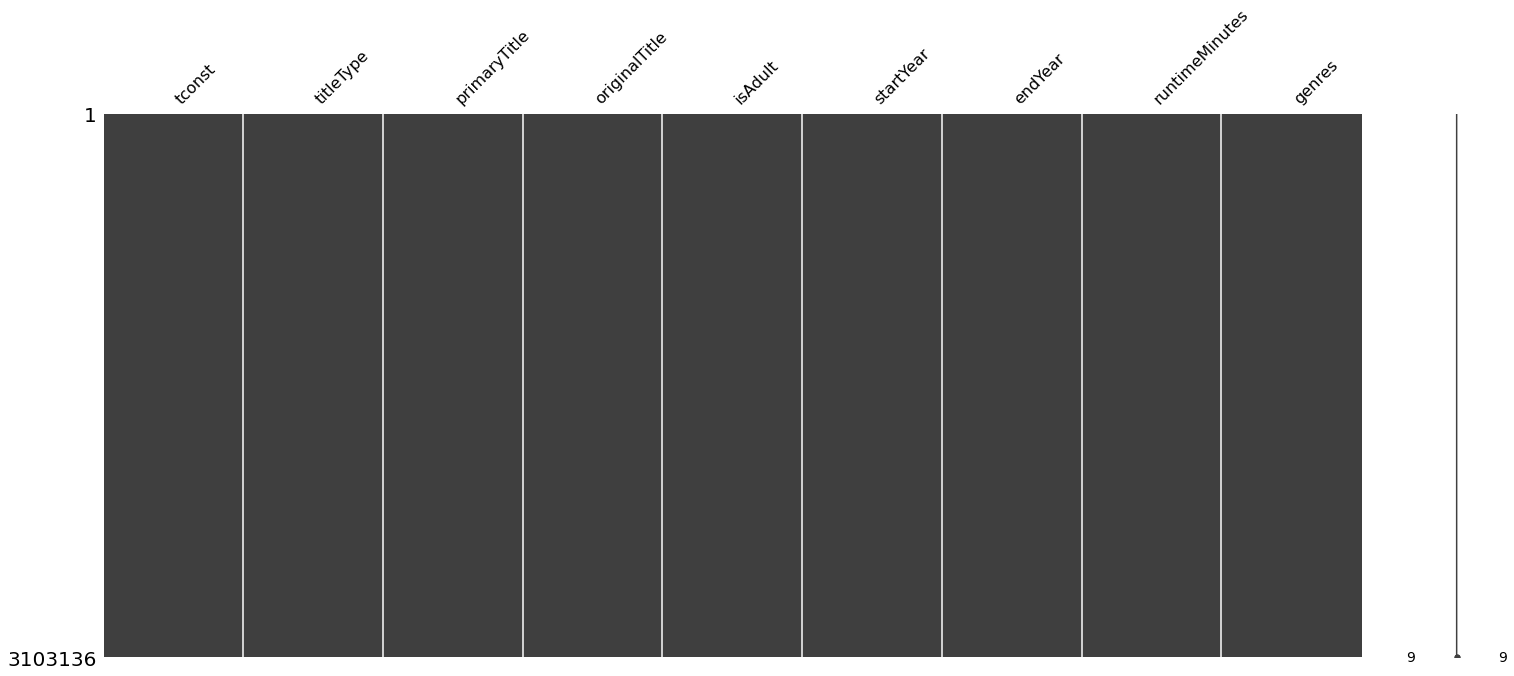

In [ ]:
msno.matrix(data)

# Heatmap - Usado para identificar se existe uma relação na presença de valores nulos entre cada uma das colunas. Como a base de dados foi tratada o gráfico é  uniforme 



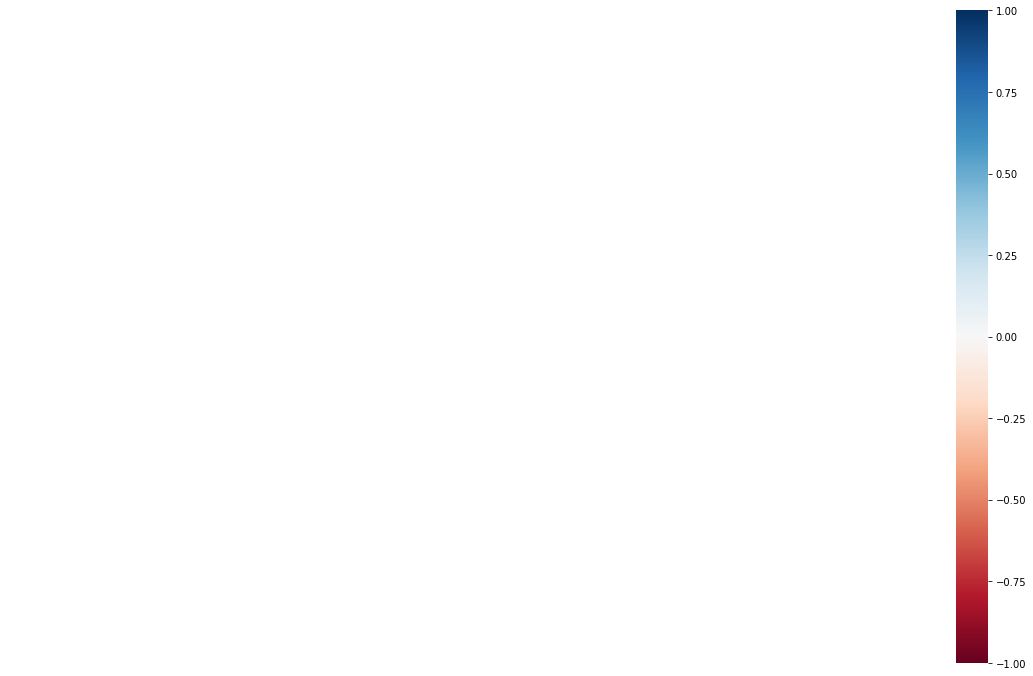

In [ ]:
msno.heatmap(df)

# Nesse gráfico de dispersão podemos ver a relação do tempo de duração dos filmes no decorrer do tempo, como é mostrado no gráfico abaixo podemos notar que os filmes vão ficando com maior duração durante os anos.

In [ ]:
df_correlacao_ano_tempo = data[['startYear', 'runtimeMinutes','titleType']].dropna()
# removendo valores com \N
df_correlacao_ano_tempo.drop(df_correlacao_ano_tempo[df_correlacao_ano_tempo['runtimeMinutes'] == '\\N'].index, inplace = True)
# removendo anos com \N
df_correlacao_ano_tempo.drop(df_correlacao_ano_tempo[df_correlacao_ano_tempo['startYear'] == '\\N'].index, inplace = True)
# removendo todos os valores que nao sejam filmes
df_correlacao_ano_tempo.drop(df_correlacao_ano_tempo[df_correlacao_ano_tempo['titleType'] != 'movie'].index, inplace = True)
# transformando os valores das colunas de ano e tempo de duração em inteiros para ser possivel agrupar
df_correlacao_ano_tempo['startYear'] = df_correlacao_ano_tempo['startYear'].astype(int)
df_correlacao_ano_tempo['runtimeMinutes'] = df_correlacao_ano_tempo['runtimeMinutes'].astype(int)
# agrupando a data e criando uma média do tempo de duração
df_correlacao_ano_tempo = df_correlacao_ano_tempo.groupby(['startYear'])['runtimeMinutes'].mean().reset_index()
# plotando o gráfico de dispersão 
fig=px.scatter(df_correlacao_ano_tempo, x = 'startYear', opacity=0.9, y = 'runtimeMinutes', log_x = True, width = 800)
fig.update_layout(title = 'Tempo de Duração X Ano de Início dos Filmes')
fig.update_xaxes(title = 'Ano de Inicio')
fig.update_yaxes(title = 'Tempo de Duração')
fig.show()


##Quanto tempo em média dua uma serie ?
####Em torno de 2 anos e meio

In [ ]:

conditionToEndYear = (data['endYear'] != '\\N') & (data['endYear'] != 'NaN') & (data['endYear'] != 'None') & (data['endYear'] != '')
conditionToStartYear = (data['startYear'] != '\\N') & (data['startYear'] != 'NaN') & (data['startYear'] != 'None') & (data['startYear'] != '')
conditionTitleType = (data['titleType'] != '\\N') & (data['titleType'] != 'NaN') & (data['titleType'] != 'None') & (data['titleType'] != '')
conditionOnlySeries = (data['titleType'] == 'tvSeries')

df_filtrado = data[(conditionToEndYear) & (conditionToStartYear) & (conditionTitleType) & (conditionOnlySeries)]
df_filtrado['anos_duracao'] = (df_filtrado['endYear'].astype(int) - df_filtrado['startYear'].astype(int))
df_filtrado['anos_duracao'].mean()




2.571283064292108

## Quais são os top 10 títulos mais longos ?

In [ ]:
df['runtimeMinutes'] = np.where(df['runtimeMinutes']=='\\N',0,df['runtimeMinutes'])
df['runtimeMinutes'] = df['runtimeMinutes'].apply(pd.to_numeric,errors = 'ignore')
longmins = df.nlargest(10,'runtimeMinutes')['primaryTitle']

x = 'Totais'
y = 'top 10 títulos mais longos'
fig = px.bar(x = [i for i in sorted(longmins.index)],y = [i for i in sorted(longmins)],color = [i for i in sorted(longmins)],template='plotly_dark')
fig.update_layout(xaxis_title = f'{str(x).title()}',yaxis_title = f'{str(y).title()}',title = f'Distribuição dos {str(x).title()} & {str(y).title()}')
fig.show()

##Qual o tempo média de duração das series e minisséries ?

In [ ]:

conditionToEndYear = (data['endYear'] != '\\N') & (data['endYear'] != 'NaN') & (data['endYear'] != 'None') & (data['endYear'] != '')
conditionToStartYear = (data['startYear'] != '\\N') & (data['startYear'] != 'NaN') & (data['startYear'] != 'None') & (data['startYear'] != '')
conditionTitleType = (data['titleType'] != '\\N') & (data['titleType'] != 'NaN') & (data['titleType'] != 'None') & (data['titleType'] != '')
df_filtrado = data[(conditionToEndYear) & (conditionToStartYear) & (conditionTitleType) ]
df_filtrado['anos_duracao'] = (df_filtrado['endYear'].astype(int) - df_filtrado['startYear'].astype(int))
df_filtrado['anos_duracao'].mean()
df_filtrado = df_filtrado.groupby(['titleType'])['anos_duracao'].mean().reset_index()
df_filtrado
fig = px.funnel(df_filtrado, x='anos_duracao', y='titleType')
fig.show()


df = px.data.tips()
fig = px.pie(df_filtrado, values='anos_duracao', names='titleType')
fig.show()

##Mapa de calor que indica a proporção de filmes adultos vs filmes amigáveis para a família

In [ ]:
isadult = Counter(df.isAdult)
x = 'Adulto v/s Amigável para a família'
y = 'Totais'
fig = px.bar(x = [i[0] for i in isadult.items()],y = [i[1] for i in isadult.items()],color = [i[1] for i in isadult.items()],template='plotly_dark')
fig.update_layout(xaxis_title = f'{str(x).title()}',yaxis_title = f'{str(y).title()}',title = f'{str(x).title()} & {str(y).title()}',height = 500,width = 700)
fig.show()